In [41]:
import pandas
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly as pt
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.patches as mpatches


df = pandas.read_csv("1335.vdb.tab", sep="\t", header =None) 
#Récupère la liste de nombre, correspondant aux comptage des différents espèces en fonction des lieu de prélevement
#2=door_in_1 ; 3=door_in_2 ; 4=faucet_handle_1 ; 5=faucet_handle_2 ; 6=sink_floor_1 ; 7=sink_floor_2
#8=soap_dispenser_1 ; 9=stall_in_1 ; 10=toilet_floor_1 ; 11=toilet_floor_1 ; 12=toilet_flush_handle_1
#13=toilet_flush_handle_2 ; 14=toilet_seat_1 ; 15=toilet_seat_2
def getcountsfromrow(row):
    l_l = [ int(row[2]),
            int(row[3]),
            int(row[4]),
            int(row[5]),
            int(row[6]),
            int(row[7]),
            int(row[8]),
            int(row[9]),
            int(row[10]),
            int(row[11]),
            int(row[12]),
            int(row[13]),
            int(row[14]),
            int(row[15]) ]
    return l_l

"""
Code pour generer dictionnaire. 

Sous forme { name : "nomDeLaTaxo", 
count : list de compte pour chaque localisation, 
children : liste des niveau plus précis venant de cette taxo}

Au prealable, avec cat 1335.vdb.tab | cut -f 2 | cut -d ";" -f 1 | uniq
OTUConTaxonomy"Bacteria(100)  => on a confirmé que ce sont toutes Bacteria
"""
def getDicoTaxo(df):
    dicotaxo = { "name" : "Bacteria", "count" : [0 for i in range(14)], "children" : []}
    for index,row in df.iterrows():
        leveltax = row[1].split(';')  # uniquement indexes >=1 m'interessent 
        if index > 0:
            COUNTS = getcountsfromrow(row)
            tmp5 = {}
            tmp4 = {}
            tmp3 = {}
            tmp2 = {}
            tmp1 = {}
            tmp5["name"] = leveltax[5]
            tmp4["name"] = leveltax[4]
            tmp3["name"] = leveltax[3]
            tmp2["name"] = leveltax[2]
            tmp1["name"] = leveltax[1]      
            tmp5["count"] =  getcountsfromrow(row)
            tmp5["children"] = []  # lowest level
            tmp4["count"] =  getcountsfromrow(row)
            tmp4["children"] = [tmp5]
            tmp3["count"] =  getcountsfromrow(row)
            tmp3["children"] = [tmp4]
            tmp2["count"] =  getcountsfromrow(row)
            tmp2["children"] = [tmp3]
            tmp1["count"] = getcountsfromrow(row)
            tmp1["children"] = [tmp2]
            tmpcounts = dicotaxo["count"]
            dicotaxo["count"] = np.add(tmpcounts, COUNTS)
            if leveltax[1] not in [m["name"] for m in dicotaxo["children"]] :
                dicotaxo["children"].append(tmp1)
            else:
                for m in dicotaxo["children"]:
                    if m["name"] == leveltax[1]:
                        tmpc = m["count"]
                        m["count"] = np.add(tmpc, COUNTS)
                        if leveltax[2] not in [n["name"] for n in m["children"]] :
                            m["children"].append(tmp2)
                        else:
                            for n in m["children"]:
                                if n["name"] == leveltax[2]:
                                    tmpc = n["count"]
                                    n["count"] = np.add(tmpc, COUNTS)
                                    if leveltax[3] not in [o["name"] for o in n["children"]]:
                                        n["children"].append(tmp3)
                                    else: 
                                        for o in n["children"]:
                                            if o["name"] == leveltax[3]:
                                                tmpc = o["count"]
                                                o["count"] = np.add(tmpc,COUNTS)
                                                if leveltax[4] not in [p["name"] for p in o["children"]]:
                                                    o["children"].append(tmp4)
                                                else:
                                                    for p in o["children"]:
                                                        if p["name"] == leveltax[4]:
                                                            tmpc = p["count"]
                                                            p["count"] = np.add(tmpc, COUNTS)
                                                            if leveltax[5] not in [q["name"] for q in p["children"]]:
                                                                p["children"].append(tmp5)
                                                            else:
                                                                for q in p["children"]:
                                                                    if q["name"] == leveltax[5]:
                                                                        tmpc = q["count"]
                                                                        q["count"] = np.add(tmpc, COUNTS)
                                                                        q["children"] = []
                                                                        # this is the lowest level                                        
    return dicotaxo



In [42]:
"""
Méthodes pour récupérer des données intéréssantes du dicoTaxo ou du DF en fonction de la figure voulue
"""

#Méthode pour récupérer le niveau de taxo demander (convertie en chiffre)
def convertNiv(niveau):
    if niveau.upper() == "REGNE":
        return 1
    if niveau.upper() == "PHYLUM":
        return 2
    if niveau.upper() == "CLASSE":
        return 3
    if niveau.upper() == "ORDRE":
        return 4
    if niveau.upper() == "FAMILLE":
        return 5
    if niveau.upper() == "GENRE":
        return 6

#Permet créer un dico pour chaque niveau
def dicoListeNiveau(nomList, dico):
    dico[nomList] = []
    
"""
Méthode 1 : En fonction du niveaux de taxo récupéré donnne pour l'espèce le comptage en fonction du lieu
Input : niveau taxo Regne;Phylum;Classe;Ordre;Famille;Genre
Output : liste de vecteurs ; 1er : vecteur des espèces, 
puis 1 vecteurs par localisation (1 vecteur donne le comptage pour l'espèce dans la localisation donnée)
Ordre pour la localisation : "door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"
"""
def getNiv(niveau,dicoTaxo):
    niv = convertNiv(niveau)
    vecteurs = []
    dicoListeNivx = {}
    #Regne 
    listeRegne = []
    #Regne compte
    listelRegne = []
    #Autre niveau
    listePhylum =[]
    listeClasse =[]
    listeOrdre =[]
    listeFamille =[]
    listeGenre =[]
    #autre niveau compte
    for i in range(1,15):
        nomList = f"listel{i}" + niveau.lower()
        dicoListeNiveau(nomList,dicoListeNivx )

    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name" and niv == 1:
            listeRegne.append(v1)
            vecteurs.append(listeRegne)
        elif k1 == "count" and niv == 1:
            listelRegne.append(v1)
            vecteurs.append(listelRegne)
        elif k1 == "children" and niv > 1: 
            for phylum in dicoTaxo['children']:
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" and niv == 2:
                        listePhylum.append(v2)
                    elif k2 == "count" and niv == 2:
                        for i in range(0,14):
                            numList = i+1
                            nomList = f"listel{numList}" + niveau.lower()
                            dicoListeNivx[nomList].append(v2[i])

                    #Descend dans les niveau plus précis
                    elif k2 == "children" and niv > 2:
                        for classe in v2:
                            for k3, v3 in classe.items():
                                #Récupère que pour la classe
                                if k3 == "name" and niv == 3:
                                    listeClasse.append(v3)
                                elif k3 == "count" and niv == 3:
                                     for i in range(0,14):
                                        numList = i+1
                                        nomList = f"listel{numList}" + niveau.lower()
                                        dicoListeNivx[nomList].append(v3[i])
                                #Descend dans les niveau plus précis
                                elif k3 == "children" and niv > 3:
                                    for ordre in v3:
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour l'ordre
                                            if k4 == "name" and niv == 4:
                                                listeOrdre.append(v4)
                                            elif k4 == "count" and niv == 4:
                                                for i in range(0,14):
                                                    numList = i+1
                                                    nomList = f"listel{numList}" + niveau.lower()
                                                    dicoListeNivx[nomList].append(v4[i])
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" and niv > 4:
                                                for famille in v4:
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour la famille
                                                        if k5 == "name" and niv == 5:
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" and niv == 5:
                                                            for i in range(0,14):
                                                                numList = i+1
                                                                nomList = f"listel{numList}" + niveau.lower()
                                                                dicoListeNivx[nomList].append(v5[i])
                                                        #Descend dans les niveau plus précis
                                                        elif k5 == "children" and niv > 5:
                                                            for genre in v5:
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour la famille
                                                                    if k6 == "name" and niv == 6:
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" and niv == 6:
                                                                        for i in range(0,14):
                                                                            numList = i+1
                                                                            nomList = f"listel{numList}" + niveau.lower()
                                                                            dicoListeNivx[nomList].append(v6[i])
                                                                    

    #Forme les vecteurs en fonction du niveau de taxo voulu.
    if niv == 2:
        vecteurs.append(listePhylum);vecteurs.append(dicoListeNivx['listel1phylum']);vecteurs.append(dicoListeNivx['listel2phylum']);vecteurs.append(dicoListeNivx['listel3phylum'])
        vecteurs.append(dicoListeNivx['listel4phylum']);vecteurs.append(dicoListeNivx['listel5phylum']);vecteurs.append(dicoListeNivx['listel6phylum']);vecteurs.append(dicoListeNivx['listel7phylum'])
        vecteurs.append(dicoListeNivx['listel8phylum']);vecteurs.append(dicoListeNivx['listel9phylum']);vecteurs.append(dicoListeNivx['listel10phylum']);vecteurs.append(dicoListeNivx['listel11phylum'])
        vecteurs.append(dicoListeNivx['listel12phylum']);vecteurs.append(dicoListeNivx['listel13phylum']);vecteurs.append(dicoListeNivx['listel14phylum']);
    if niv == 3:
        vecteurs.append(listeClasse);vecteurs.append(dicoListeNivx['listel1classe']);vecteurs.append(dicoListeNivx['listel2classe']);vecteurs.append(dicoListeNivx['listel3classe'])
        vecteurs.append(dicoListeNivx['listel4classe']);vecteurs.append(dicoListeNivx['listel5classe']);vecteurs.append(dicoListeNivx['listel6classe']);vecteurs.append(dicoListeNivx['listel7classe'])
        vecteurs.append(dicoListeNivx['listel8classe']);vecteurs.append(dicoListeNivx['listel9classe']);vecteurs.append(dicoListeNivx['listel10classe']);vecteurs.append(dicoListeNivx['listel11classe'])
        vecteurs.append(dicoListeNivx['listel12classe']);vecteurs.append(dicoListeNivx['listel13classe']);vecteurs.append(dicoListeNivx['listel14classe']);
    if niv == 4:
        vecteurs.append(listeOrdre);vecteurs.append(dicoListeNivx['listel1ordre']);vecteurs.append(dicoListeNivx['listel2ordre']);vecteurs.append(dicoListeNivx['listel3ordre'])
        vecteurs.append(dicoListeNivx['listel4ordre']);vecteurs.append(dicoListeNivx['listel5ordre']);vecteurs.append(dicoListeNivx['listel6ordre']);vecteurs.append(dicoListeNivx['listel7ordre'])
        vecteurs.append(dicoListeNivx['listel8ordre']);vecteurs.append(dicoListeNivx['listel9ordre']);vecteurs.append(dicoListeNivx['listel10ordre']);vecteurs.append(dicoListeNivx['listel11ordre'])
        vecteurs.append(dicoListeNivx['listel12ordre']);vecteurs.append(dicoListeNivx['listel13ordre']);vecteurs.append(dicoListeNivx['listel14ordre']);
    if niv == 5:
        vecteurs.append(listeFamille);vecteurs.append(dicoListeNivx['listel1famille']);vecteurs.append(dicoListeNivx['listel2famille']);vecteurs.append(dicoListeNivx['listel3famille'])
        vecteurs.append(dicoListeNivx['listel4famille']);vecteurs.append(dicoListeNivx['listel5famille']);vecteurs.append(dicoListeNivx['listel6famille']);vecteurs.append(dicoListeNivx['listel7famille'])
        vecteurs.append(dicoListeNivx['listel8famille']);vecteurs.append(dicoListeNivx['listel9famille']);vecteurs.append(dicoListeNivx['listel10famille']);vecteurs.append(dicoListeNivx['listel11famille'])
        vecteurs.append(dicoListeNivx['listel12famille']);vecteurs.append(dicoListeNivx['listel13famille']);vecteurs.append(dicoListeNivx['listel14famille']);
    if niv == 6:
        vecteurs.append(listeGenre);vecteurs.append(dicoListeNivx['listel1genre']);vecteurs.append(dicoListeNivx['listel2genre']);vecteurs.append(dicoListeNivx['listel2genre'])
        vecteurs.append(dicoListeNivx['listel4genre']);vecteurs.append(dicoListeNivx['listel5genre']);vecteurs.append(dicoListeNivx['listel6genre']);vecteurs.append(dicoListeNivx['listel7genre'])
        vecteurs.append(dicoListeNivx['listel8genre']);vecteurs.append(dicoListeNivx['listel9genre']);vecteurs.append(dicoListeNivx['listel10genre']);vecteurs.append(dicoListeNivx['listel11genre'])
        vecteurs.append(dicoListeNivx['listel12genre']);vecteurs.append(dicoListeNivx['listel13genre']);vecteurs.append(dicoListeNivx['listel14genre']);
    
    return vecteurs

"""
Méthode 2: pour récupérer les vecteurs de comptage avec un comptages assez important.
"""
def abondanceImportant(vecteurs, comptageMin):
    sum = 0
    lgVecteur = len(vecteurs[0])
    rangeb = len(vecteurs[0])-1
    listNumsup = []
    for i in range(0,rangeb):
        sum = vecteurs[1][i] +vecteurs[2][i]+vecteurs[3][i]+vecteurs[4][i]+vecteurs[5][i]+vecteurs[6][i]+vecteurs[7][i]+vecteurs[8][i]+vecteurs[9][i]+vecteurs[10][i]+vecteurs[11][i]+vecteurs[12][i]+vecteurs[13][i]+vecteurs[14][i]
        if sum < comptageMin :
            listNumsup.append(i)
    nbSup = 0
    for i in listNumsup:
        if(lgVecteur == len(vecteurs[0]) ):
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        else:
            nbSup = nbSup + 1
            i = i-nbSup
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        
    return vecteurs 

"""
Methode 3 : Création matrice pour heat map a partir d'une liste de vecteurs.
"""
def matrice(vecteurs):
    mat = np.array([vecteurs[1],vecteurs[2],vecteurs[3],vecteurs[4],vecteurs[5],vecteurs[6],vecteurs[7],vecteurs[8],vecteurs[9],
           vecteurs[10],vecteurs[11],vecteurs[12],vecteurs[13],vecteurs[14]])
    return mat


"""
Méthodes utilisant le dicoTaxo où l'on a déjà récupéré tout les comptages par niveau et taxo.
"""

"""
Méthode 4 : Avec le niveau de Taxo créer une dataframe panda sur lequel peut travailler pour différentes figures.
Input : dicoTaxo créer avec la méthode 1
Output : dataFrame de 17 colonnes
Colonne créer : 
Nvx_taxo : Indique de qu'elle niveau la taxo appartient (Regne;Phylum;Classe;Ordre;Famille;Genre)
Taxo : Donne la taxo 
Parent : Donne le parent pour cette taxo
LocN : Donne le comptage pour chaque N localisation pour cette taxo. 
Localisation : "door_in_1","door_in_2", "faucet_handle_1", "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", "toilet_floor_2", "toilet_flush_handle_1","toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"
"""
def getDF(dicoTaxo):
    listeDf=[]
    listeRegne=["regne"]
    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name":
            listeRegne.append(v1)
            listeRegne.append("none")
        elif k1 == "count" :
            for i in range(0,14):
                listeRegne.append(int(v1[i]))
            listeDf.append(listeRegne)
        elif k1 == "children":
            for phylum in dicoTaxo['children']:
                listePhylum = ["phylum"]
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" :
                        listePhylum.append(v2)
                        listePhylum.append(listeRegne[1])
                    elif k2 == "count" :
                        for i in range(0,14):
                            listePhylum.append(int(v2[i]))
                        listeDf.append(listePhylum)
                    #Descend dans les niveau plus précis
                    elif k2 == "children" :
                        for classe in v2:
                            listeClasse = ["classe"]
                            for k3, v3 in classe.items():
                                #Récupère que pour le phylum
                                if k3 == "name" :
                                    listeClasse.append(v3)
                                    listeClasse.append(listePhylum[1])
                                elif k3 == "count" :
                                    for i in range(0,14):
                                        listeClasse.append(int(v3[i]))
                                    listeDf.append(listeClasse)
                                #Descend dans les niveau plus précis
                                elif k2 == "children" :
                                    for ordre in v3:
                                        listeOrdre = ["ordre"]
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour le phylum
                                            if k4 == "name" :
                                                listeOrdre.append(v4)
                                                listeOrdre.append(listeClasse[1])
                                            elif k4 == "count" :
                                                for i in range(0,14):
                                                    listeOrdre.append(int(v4[i]))
                                                listeDf.append(listeOrdre)
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" :
                                                for famille in v4:
                                                    listeFamille = ["famille"]
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour le phylum
                                                        if k5 == "name" :
                                                            listeFamille.append(v5)
                                                            listeFamille.append(listeOrdre[1])
                                                        elif k5 == "count" :
                                                            for i in range(0,14):
                                                                listeFamille.append(int(v5[i]))
                                                            listeDf.append(listeFamille)
                                                         #Descend dans les niveau plus précis
                                                        elif k5 == "children" :
                                                            for genre in v5:
                                                                listeGenre = ["genre"]
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour le phylum
                                                                    if k6 == "name" :
                                                                        listeGenre.append(v6)
                                                                        listeGenre.append(listeFamille[1])
                                                                    elif k6 == "count" :
                                                                        for i in range(0,14):
                                                                            listeGenre.append(int(v6[i]))
                                                                        listeDf.append(listeGenre)
                                                                    
    listelegColonne=["Nvx_taxo","Taxo","Parent","door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

"""
Méthode 5 : Récupère le dataframe pour une seul taxo voulu
Input : dataframe créer avec méthode 4 , et taxo voulu (Regne;Phylum;Classe;Ordre;Famille;Genre)
Output : dataframe avec seulement les lignes corespondant à taxo.
"""
def getDFFonctionTaxo(df, taxo):
    dfTaxo = df.copy()
    return df[df['Nvx_taxo']==taxo]
"""
Méthode 6 : Récupère tableau avec colonne suprimmer
"""
def getDFLoc(df, listeColonneSup):
    dfLoc = df.copy()
    dfLoc.drop(columns =listeColonneSup , inplace= True )
    return dfLoc

"""
Méthode 7 : Récupère la localisation
"""
def getLoc(niv):
    if niv == 0:
        return "door_in_1"
    elif niv == 1:
        return "door_in_2"
    elif niv == 2:
        return "faucet_handle_1" 
    elif niv == 3:
        return "faucet_handle_2" 
    elif niv == 4:
        return "sink_floor_1"
    elif niv == 5:
        return "sink_floor_2"
    elif niv == 6:
        return "soap_dispenser_1"
    elif niv == 7:
        return "stall_in_1"
    elif niv == 8:
        return "toilet_floor_1"
    elif niv == 9:
        return "toilet_floor_2"
    elif niv == 10:
        return "toilet_flush_handle_1"
    elif niv == 11:
        return "toilet_flush_handle_2"
    elif niv == 12:
        return "toilet_seat_1"
    elif niv == 13:
        return "toilet_seat_2"
    

"""
Méthode 8 : Recréer une dataFrame à partir de celle créer dans la méthode 4  (Ici plus compacte) 
Input : dataframe de getDF
Ouput : dataframe de 5 colonnes ("Nvx_taxo","Taxo", "Parent", "Localisation", "Comptage")
"""
def getDFTree(df):
    listeDf=[]
    for j in range(0,14):
        for i in df.index:
            listeLigne = [df["Nvx_taxo"][i]]
            listeLigne.append(df["Taxo"][i])
            listeLigne.append(df["Parent"][i])
            loc = getLoc(j)
            listeLigne.append(loc)
            listeLigne.append(df[loc][i])
            listeDf.append(listeLigne)
    listelegColonne=["Nvx_taxo","Taxo", "Parent", "Localisation", "Comptage"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

"""
Méthode 9 : Méthode pour spliter un string comportant différente espèces et permet de retourner la liste de ces espèces.
Input : String de forme "Bacterie(100),ActinoBacterie(100)"
Ouput : Liste des espèces. ([Bacterie,ActinoBacterie ])
"""
def listeTaxo(stringTaxo):
    leveltax = stringTaxo[0].split(';')
    listeOfTaxo = []
    for i in range(0 , len(leveltax)-1):
        justeTaxo = leveltax[i].split("(")
        listeOfTaxo.append(justeTaxo[0])
    return listeOfTaxo
    
"""
Méthode 10 : Recréer une dataFrame de 20 colonnes à partir des donnée brut récupérer. 
Cette méthode est utilisr pour le treeMap Hiérachique, permettant d'avoir l'information sur l'emboitement taxonomique des espèces. 
Input : dataframe récupéré du fihcier csv 1335.vdb.tab
Ouput : dataframe de 20 colonnes. 
6 premières colonnes : Les 6 différents niveaux taxonomique
Puis les 14 localisations ou le compte d'abondance à été fait
"""
def getDFTreeMapTaxo(df):
    listeDf=[]
    
    for i in df.index:
        listeLigne=[]
        if i > 0:
            #Recupère diférente taxo
            listeofTaxo = listeTaxo([df[1][i]])
            for e in listeofTaxo:
                listeLigne.append(e)
            for j in range (2,16 ):
                listeLigne.append(df[j][i])

            listeDf.append(listeLigne)
    listelegColonne=["Regne","Phylum", "Classe", "Ordre", "Famille", "Genre",
                     "door_in_1","door_in_2", "faucet_handle_1", 
               "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

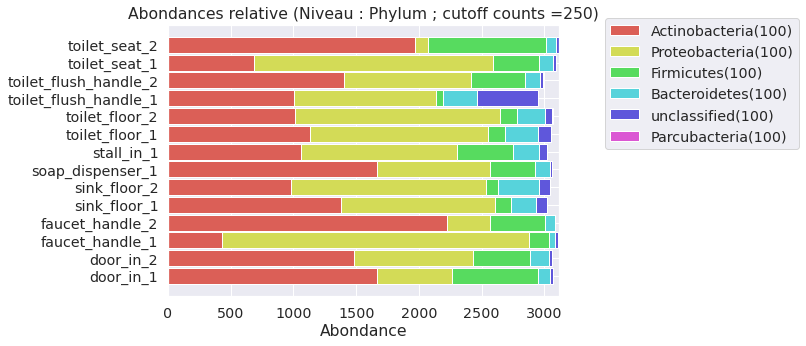

In [69]:
"""
Création de differente figures
"""

"""
Figure 1 : BarPlot recupère pour une Taxo donnéer 
les abondances des espèces en fonctions de leur localisation
"""

SELECTED = "Phylum" 
cutoffk = 250
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 



localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs, cutoffk)

vecteursTaxo = vecteursTrier[0]
vecteursComptage = np.delete(vecteursTrier, (0), axis=0)
VecteursComptInverse=np.fliplr(np.rot90(vecteursComptage,3))

N=len(VecteursComptInverse[0])
ind = np.arange(N)

l_loc = []
for i in range(len(vecteursTaxo)):
    l_loc.append(VecteursComptInverse[i])

height = 0.9
fig = plt.figure(figsize=[7, 5])
bars = []
cols = sns.color_palette("hls",len(vecteursTaxo)) #COLORS
#NOTE:max colors for "colorblind" are 10, look for solution soon!
cumulated = np.zeros(len(l_loc[0]),dtype=int)
for i in range(len(vecteursTaxo)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,[int(elem) for elem in l_loc[i] ], height,color=cols[i])
    else: 
        tmpbarobject = plt.barh(ind, [int(elem) for elem in l_loc[i] ],height, left=cumulated, color=cols[i]) 
    
    listeInt= [int(elem) for elem in l_loc[i] ]
    cumulated = np.add(listeInt,cumulated)
    bars.append(tmpbarobject[0])
        

plt.xlabel('Abondance') 
plt.title('Abondances relative (Niveau : ' + SELECTED + " ; cutoff counts ="+ str(cutoffk)+")") 
plt.yticks(ind, (localisation)) 
# legende dehors du plot area avec: bbbox_to_anchor
plt.legend(bars, vecteursTaxo, bbox_to_anchor=(1.10, 1.05))  
plt.savefig('plots/barPlot_AbondRelatives_Phylum.pdf', format="pdf", dpi=300,  bbox_inches = 'tight')

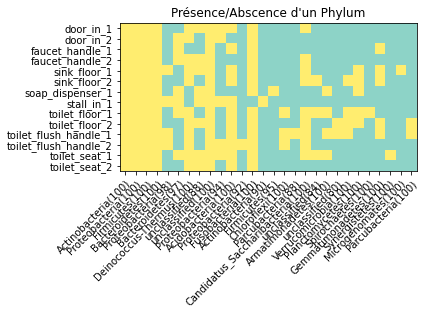

In [44]:
"""
Figure 2 : HeatMap représentant, pour un niveau de taxo donnée, 
la présence ou abscence d'une expèce dans une localisation.
"""

dicoTaxoTest = getDicoTaxo(df)
Niveau = "Phylum"
vecteurs = getNiv(Niveau,dicoTaxoTest)
mat = matrice(vecteurs)
newMat= []

#Modifie la matrice pour avoir 0 : abscence et 1: présence d'une espèce dans une localisation.
for i in mat:
    listemat = []
    for j in i: 
        if j > 0:
            listemat.append(1)
        else:
            listemat.append(0)
    newMat.append(listemat)
    
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]
newMatInverser=np.fliplr(np.rot90(newMat,3))
matinverser=np.fliplr(np.rot90(mat,3))

fig, ax = plt.subplots()
im = ax.imshow(newMat,  cmap = plt.cm.Set3)

ax.set_xticks(np.arange(len(espece)))
ax.set_yticks(np.arange(len(localisation)))

ax.set_xticklabels(espece)
ax.set_yticklabels(localisation)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title(f"Présence/Abscence d'un {Niveau}")
fig.tight_layout()
plt.savefig('plots/heatMap_Phylum.pdf', format="pdf", dpi=300,  bbox_inches = 'tight')
plt.show()

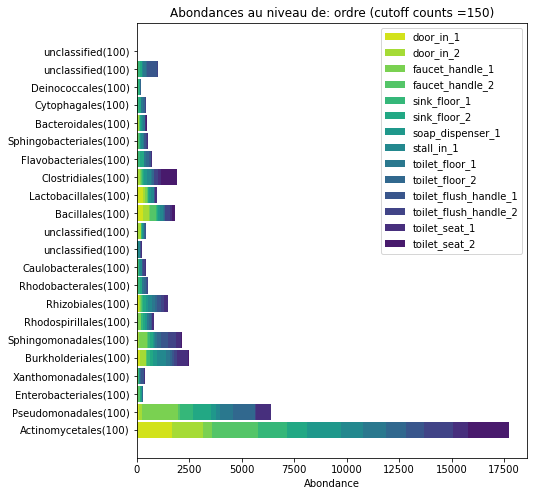

In [45]:
"""
Figure 3 : BarPlot recupère pour une Taxo donnéer 
les abondances des espèces dans chaque localisation
"""

SELECTED = "ordre" 
cutoffk = 150
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs, cutoffk)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
for i in range(len(localisation)):
    l_loc.append(vecteursTrier[i+1]) #car vecteursTrier[1] --> "door_in_1"
    

height = 0.9
fig = plt.figure(figsize=[7, 8])
bars = []
cols = sns.color_palette('viridis_r',14) #COLORS
cumulated = np.zeros(len(l_loc[0]),dtype=int)
for i in range(len(localisation)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,l_loc[i], height,color=cols[i])
    else: 
        tmpbarobject = plt.barh(ind, l_loc[i],height, left=cumulated, color=cols[i]) 

    cumulated = np.add(l_loc[i],cumulated)
    bars.append(tmpbarobject[0])

plt.xlabel('Abondance') 
plt.title('Abondances au niveau de: ' + SELECTED + " (cutoff counts ="+ str(cutoffk)+")") 
plt.yticks(ind, (selected_niv)) 
# si besoin : legende dehors du plot area avec: bbbox_to_anchor
#plt.legend(bars, localisation, bbox_to_anchor=(1.5, 1)) 
plt.legend(bars,localisation)
plt.savefig('plots/bar_legendLocalisation.pdf', format="pdf", dpi=300,  bbox_inches = 'tight')    
#plt.show()

In [46]:
"""
Figure 4 : TreeMap hiérachique
"""
dfex = px.data.tips()
df2 = getDFTreeMapTaxo(df)
fig = px.treemap(df2, path=['Regne', 'Phylum', 'Classe','Ordre', 'Famille', 'Genre'], 
                 values='toilet_seat_1')
fig.show()
#pt.io.write_image(fig, 'plots/treeMap.pdf', format='pdf', engine='kaleido')
fig.write_image("plots/treeMapToiletSeat1.pdf", engine="kaleido")
fig.write_html("plots/treeMapToiletSeat1.html")


In [47]:
"""
Figure 5 : ACP
"""

""" 
récuperation de données pour ACP
calculé utilisant niveau famille
"""
#Creéation DF avec seulement les noms des famille: (dfTaxo)
#Recupère les donnéer et format en Df
dicoTaxoTest = getDicoTaxo(df)
dfEntier= getDF(dicoTaxoTest)
dfTaxo = getDFFonctionTaxo(dfEntier, "famille")
listeColonneSuprimerPourTaxo = ["Nvx_taxo","Parent"]
dfTaxoFilter = getDFLoc(dfTaxo,listeColonneSuprimerPourTaxo )

# Prepare numpy arrays:
bacternames = dfTaxoFilter['Taxo'] #this column has microbes names
dfTaxo_tr = dfTaxoFilter.T # transpose, rows will be locations, columns the microbes
dfTaxo_tr.columns = bacternames
dfTaxo_tr.drop(index='Taxo', inplace=True)
dfTaxo_tr
# message about 'copy of a slice from a DataFrame': just ignore it


Taxo,Propionibacteriaceae(100),Corynebacteriaceae(100),Micrococcaceae(99),Micrococcaceae(100),Geodermatophilaceae(100),unclassified(100),Intrasporangiaceae(100),Mycobacteriaceae(99),Nocardioidaceae(100),Nocardiaceae(100),...,unclassified(80),Verrucomicrobiaceae(100),unclassified(100),Opitutaceae(100),Planctomycetaceae(100),Spirochaetaceae(100),Gemmatimonadaceae(100),Synergistaceae(100),unclassified(100),unclassified(100)
door_in_1,1398,86,6,49,0,41,0,5,1,4,...,0,0,0,0,0,0,0,0,0,0
door_in_2,1055,155,27,91,0,67,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
faucet_handle_1,338,19,5,35,0,6,4,0,2,2,...,0,0,0,0,0,0,1,0,0,0
faucet_handle_2,597,1470,6,19,2,41,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
sink_floor_1,202,34,452,111,109,198,44,0,46,7,...,0,0,0,0,1,0,3,0,2,0
sink_floor_2,143,41,275,111,54,142,20,0,55,3,...,0,1,0,0,1,0,1,0,0,0
soap_dispenser_1,1159,160,63,22,22,64,1,0,15,0,...,0,0,0,0,3,0,0,0,0,0
stall_in_1,630,131,0,135,9,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
toilet_floor_1,151,23,236,92,92,183,51,0,82,18,...,0,1,0,0,2,6,0,0,0,0
toilet_floor_2,171,86,251,76,45,141,42,0,32,3,...,1,0,1,0,1,0,1,0,0,1


In [56]:
"""
ACP calcul et plot
""" 
X = dfTaxo_tr.values
y = np.array(['A.doorIn','A.doorIn','B.faucetHandle','B.faucetHandle','F.sinkFloor','F.sinkFloor',
            'C.soapDispenser','D.stallIn','G.toiletFloor','G.toiletFloor','E.toiletFlushHand','E.toiletFlushHand',
            'H.toiletSeat','H.toiletSeat']) #localisation categories
pca = PCA(n_components=2)
components = pca.fit_transform(X,y)
#sns.color_palette("Spectral",len(np.unique(y)))
total_var = pca.explained_variance_ratio_.sum() * 100
colsfewer = sns.color_palette('viridis_r',len(np.unique(y))*3) #COLORS

fig = px.scatter(components, x=1,y=0, color = y , title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'} ,
                color_discrete_map={
                    "A.doorIn": 'rgb'+str(colsfewer[0]),
                    "B.faucetHandle": 'rgb'+str(colsfewer[1]),
                    "C.soapDispenser": 'rgb(0.111,0.1111,0.111)',
                    "D.stallIn": 'rgb(0.911111,0.911111,0.911111)',
                    "E.toiletFlushHand": 'rgb'+str(colsfewer[4]),
                    "F.sinkFloor": 'rgb'+str(colsfewer[12]),
                    "G.toiletFloor": 'rgb'+str(colsfewer[15]),
                    "H.toiletSeat" : 'rgb(72,40,120)'
                }) # j'ai testé ceci: https://plotly.com/python/marker-style/ avec symbol_map mais échec

fig.update_traces(marker=dict(size=15, # taille des points
                              line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))



In [57]:
#print image:
import psutil as psutil
import kaleido as kaleido
import plotly.io as pio

fig.write_image("plots/ACP.pdf", engine="kaleido")  #pip install psutil to export correctly
fig.write_html("plots/ACP.html")

fig.show()
#pt.offline.plot(fig, "figureTest.html")

In [50]:
print("end ACP")

end ACP


In [55]:
"""
Figure 6 : Clustering hierarchique
"""

"""
Preparation Donees pour CLUSTERING HIERARCHIQUE: 
utiliser GENRE.
"""
dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df2
#dans ce 'chunk' GENRE_FIL sera filtré:
GENRE_FIL = getDFFonctionTaxo(df2,"genre")
listmysum = []
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
for index, row in GENRE_FIL.iterrows():
    desiredvalues = [ int(i) for i in row[localisation] ]
    listmysum.append(sum(desiredvalues))
GENRE_FIL["TOTALABUND"] = listmysum
GENRE_FIL["TOTALABUND"].describe() #check values statistics resumé
#stablish cutoff as 5% the max total value
cutoff = GENRE_FIL["TOTALABUND"].describe()["max"]*0.05

indextodelete = GENRE_FIL[GENRE_FIL["TOTALABUND"] < cutoff].index
GENRE_FIL.drop(indextodelete, inplace=True)
# préparation de la matrice
### atention!!!! lots of conflicts with "unknown" : repeated!
GFtmp = GENRE_FIL.drop_duplicates(subset='Taxo', keep="first")
GF3 = getDFTree(GFtmp)  # essential to create 'y'
lcolsuprimer = ["Nvx_taxo","TOTALABUND"]
GF2 = GFtmp.drop(columns=lcolsuprimer)
del(GFtmp)

listmicroo = GF2['Taxo']
GF2.reindex = listmicroo #  ne marche pas, solution: faire tout
GF2tmp = GF2.loc[:,localisation].to_numpy()

GF2matrix = GF2tmp.astype("double")
GF2f = pandas.DataFrame(GF2matrix, index=listmicroo, columns=localisation)
GF2f
### ici on peut visualiser le df style matrice comme il faut pour tourner l'analyse


<ipython-input-55-c0dd5d6a4ed6>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/yum/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,door_in_1,door_in_2,faucet_handle_1,faucet_handle_2,sink_floor_1,sink_floor_2,soap_dispenser_1,stall_in_1,toilet_floor_1,toilet_floor_2,toilet_flush_handle_1,toilet_flush_handle_2,toilet_seat_1,toilet_seat_2
Taxo,,,,,,,,,,,,,,
Propionibacterium(100),1392.0,1053.0,336.0,594.0,41.0,39.0,1149.0,621.0,46.0,87.0,15.0,341.0,78.0,211.0
Friedmanniella(100),6.0,2.0,0.0,0.0,124.0,61.0,0.0,9.0,62.0,48.0,7.0,9.0,5.0,1.0
Corynebacterium(100),86.0,155.0,19.0,1467.0,31.0,41.0,159.0,131.0,23.0,86.0,4.0,794.0,234.0,1664.0
Arthrobacter(86),6.0,27.0,5.0,6.0,452.0,275.0,63.0,0.0,236.0,251.0,9.0,51.0,5.0,3.0
Kocuria(100),6.0,36.0,3.0,0.0,85.0,85.0,22.0,14.0,53.0,54.0,0.0,10.0,6.0,0.0
unclassified(100),41.0,67.0,6.0,41.0,198.0,142.0,64.0,25.0,183.0,141.0,144.0,33.0,25.0,20.0
Enhydrobacter(100),20.0,17.0,1703.0,3.0,420.0,571.0,129.0,9.0,442.0,716.0,0.0,25.0,260.0,0.0
Acinetobacter(100),35.0,59.0,7.0,13.0,142.0,272.0,71.0,55.0,134.0,271.0,4.0,14.0,58.0,5.0
Pseudomonas(95),9.0,10.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,364.0,0.0


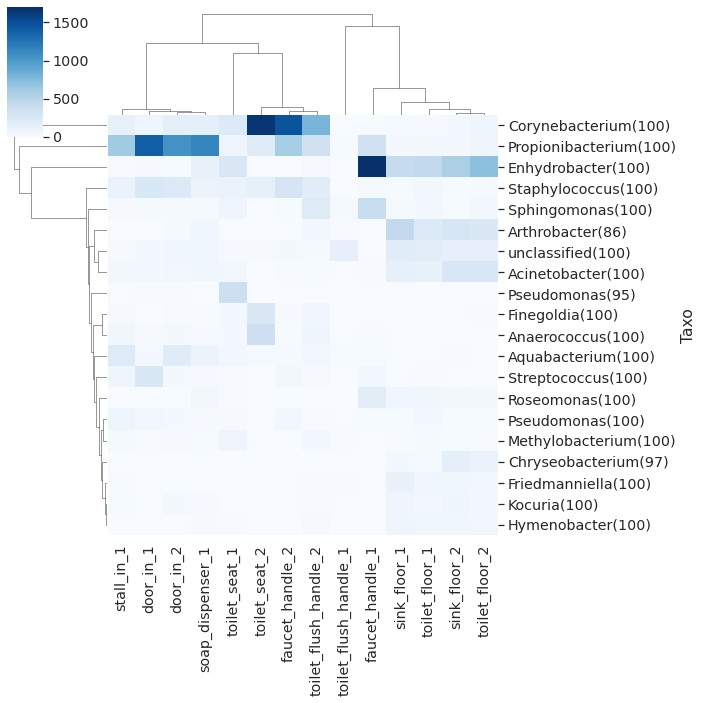

In [52]:

#calculate linkage matrix, 'average' is UPGMA
linkage = hc.linkage(GF2matrix, method='average')

y = pandas.Series((i for i in GF3["Localisation"]), index=GF3["Taxo"], name="Series") 

#mypal lmcolor and rowcol for color bar, but here is not possible with this 'y', 
# it may work if series was for example phylum (something assigned 1 to 1 to genre)

mypal = sns.cubehelix_palette(len(y), light=.9, dark=.1, reverse=True, start=1, rot=-2)
lmcolor = dict(zip(map(str,y.unique()),mypal))
rowcol = y.map(lmcolor)
sns.set(font_scale=1.3) ## new: font size bigger !!
h = sns.clustermap(GF2f, row_linkage=linkage, metric="correlation", cmap="Blues")
plt.savefig('plots/ClustHierarchiqueFontnew.pdf', format="pdf", dpi=300,  bbox_inches = 'tight')
